# First we install the necessary dependencies

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

# Then we load the images using openCV

In [9]:
def get_image_paths(folder_path):
    # Create a list to store the paths
    image_paths=[]
    # List all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image (common image extensions)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Create full image path
            file_path = os.path.join(folder_path, filename)
            # Append the path to the list of paths
            image_paths.append(file_path)
    return image_paths
         
#image_paths=get_image_paths('images')
#for image_path in image_paths:
#    print(image_path)

image_path = 'photo_2024-12-10_19-00-54 (2).jpg'  # Path to the image file
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Could not read image from {image_path}")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 1\) Edge detection
This step is paramount for most kind of image processing, because it basically allows the computer to understand the shape of an object.
To detect edges in images is firstly necessary to convert the image in gray scale, then i blurred the image using a gaussian filter with dimension 5x5 to reduce noise, this is necessary because otherwise the Canny edge detector would also be triggered by the texture of the kiwi instead of just by his borders.
The threshold for the Canny edge detector is calculated with the Otsu algorithm, which calculates the ideal threshold for each image, this has been done to avoid different beahviour to different saturation levels.

I've experimented with different scenarios
- Removing the Otsu threshold and manually setting lower_threshold=50, higher_threshold=150 (Try with manually setting other thresholds but beware of constrast differences in images)
- Replacing the 5x5 gaussian blur with a 3x3 gaussian blur
- Replacing the 5x5 gaussian blur with a 7x7 gaussian blur
- Removing the gaussian blur

I found out that the gaussian blur was essential to reduce noise before edge detection, as without the noise made it impossible to have a clear round figure

In [10]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Convert to LAB color space
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
L, A, B = cv2.split(lab)

# Normalize the L, A, B channels for better visualization
L_vis = cv2.normalize(L, None, 0, 255, cv2.NORM_MINMAX)
A_vis = cv2.normalize(A, None, 0, 255, cv2.NORM_MINMAX)
B_vis = cv2.normalize(B, None, 0, 255, cv2.NORM_MINMAX)


# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# Apply Otsu's thresholding
thresh, _ = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)
# Apply Canny edge detection using Otsu's threshold
edges = cv2.Canny(blurred, thresh/2, thresh)
# Dilate to connect edge fragments
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=2)

# 2\) Contour detection

# Finally we show the results using plots

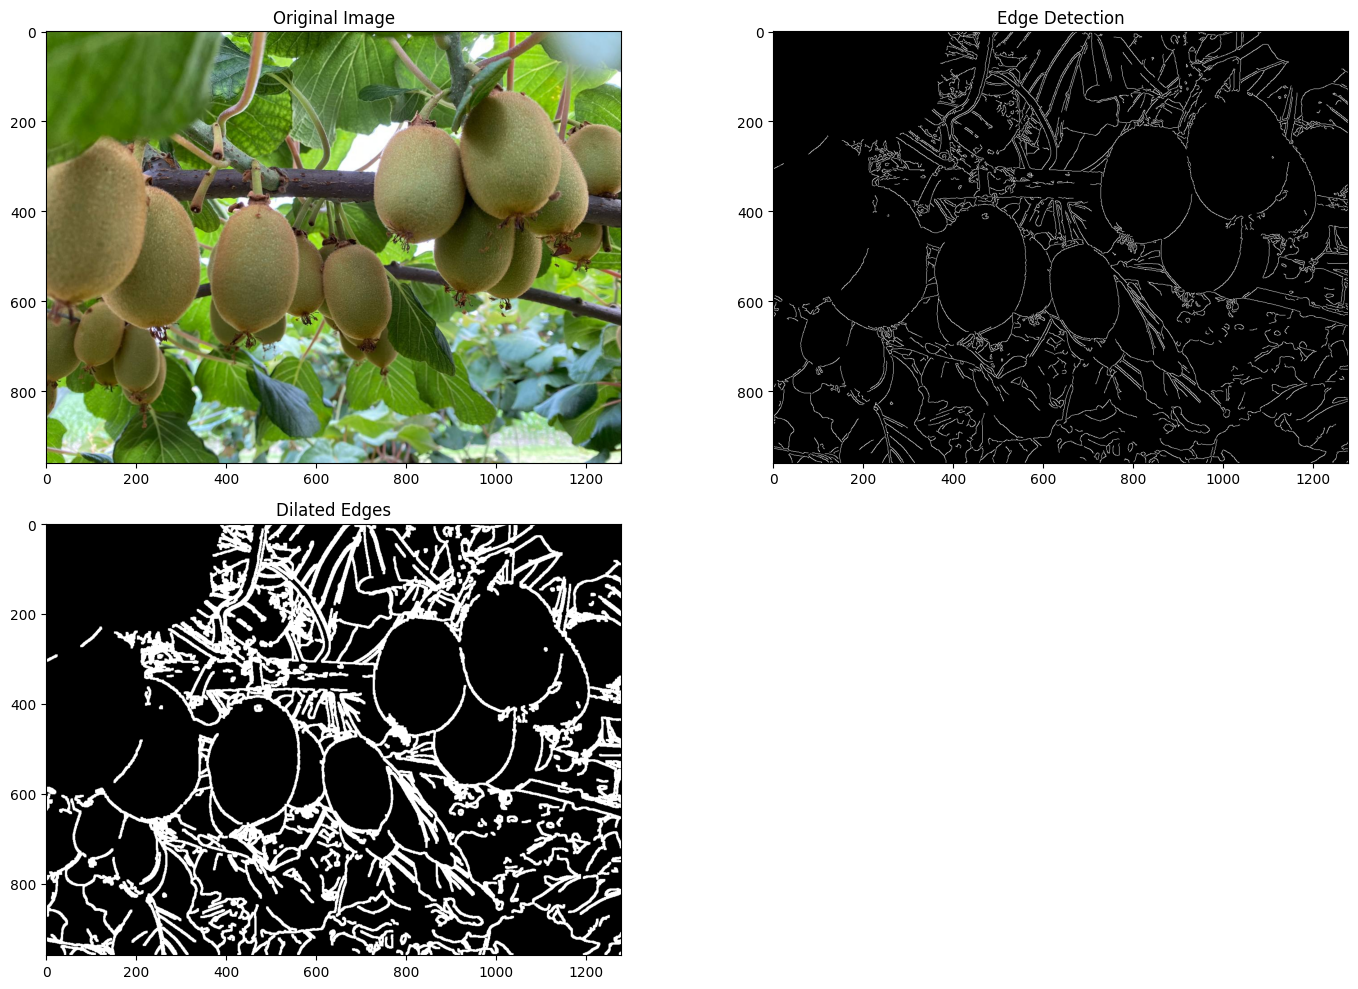

In [11]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')

plt.subplot(2, 2, 3)
plt.imshow(dilated, cmap='gray')
plt.title('Dilated Edges')

plt.tight_layout()
plt.savefig('with_otsu_dilated.png')
plt.show()
